In [2]:
import re
import time
from typing import Dict, List, Optional, Tuple

import pandas as pd
import requests
from bs4 import BeautifulSoup

# PDF text extraction
import pdfplumber


USGS_2022_LIST_URL = (
    "https://www.usgs.gov/news/national-news-release/"
    "us-geological-survey-releases-2022-list-critical-minerals"
)

MCS_2022_DIR_INDEX_URL = "https://pubs.usgs.gov/periodicals/mcs2022/"
MCS_2022_PDF_PREFIX = "mcs2022-"


# The 2022 list splits REEs individually, but MCS typically provides a "Rare-Earths" sheet
REE_NAMES = {
    "Cerium", "Dysprosium", "Erbium", "Europium", "Gadolinium", "Holmium",
    "Lanthanum", "Lutetium", "Neodymium", "Praseodymium", "Samarium",
    "Terbium", "Thulium", "Ytterbium", "Yttrium"
}


def _get(url: str, timeout: int = 30) -> str:
    """HTTP GET with basic headers."""
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; StrategicMineralsScraper/1.0; +https://example.com)"
    }
    r = requests.get(url, headers=headers, timeout=timeout)
    r.raise_for_status()
    return r.text


def fetch_critical_minerals_2022_list() -> List[str]:
    """
    Scrape the 50 mineral names from the USGS 2022 critical minerals news release page.
    Returns a list of mineral names.
    """
    html = _get(USGS_2022_LIST_URL)
    soup = BeautifulSoup(html, "html.parser")

    # Find the paragraph introducing the list, then the following UL
    anchor_text = "The 2022 list of critical minerals includes the following"
    p = None
    for cand in soup.find_all(["p", "div"]):
        if cand.get_text(" ", strip=True).startswith(anchor_text):
            p = cand
            break

    if p is None:
        raise RuntimeError("Could not locate the critical minerals list intro text on the USGS page.")

    # The list is typically in the next <ul>
    ul = p.find_next("ul")
    if ul is None:
        raise RuntimeError("Could not locate the <ul> that contains the mineral list.")

    minerals = []
    for li in ul.find_all("li", recursive=False):
        # Each bullet is like "Aluminum, used in ..."
        text = li.get_text(" ", strip=True)
        # Take the substring before the first comma
        name = text.split(",", 1)[0].strip()
        if name:
            minerals.append(name)

    # Basic sanity check
    if len(minerals) < 40:
        raise RuntimeError(f"Unexpectedly small mineral list scraped: {len(minerals)} minerals.")

    # Deduplicate while preserving order
    seen = set()
    minerals_unique = []
    for m in minerals:
        if m not in seen:
            minerals_unique.append(m)
            seen.add(m)

    return minerals_unique


def fetch_mcs_2022_pdf_index() -> Dict[str, str]:
    """
    Scrape the MCS 2022 directory index to build {slug: pdf_url}.
    Example slug: 'antimony' -> 'https://pubs.usgs.gov/periodicals/mcs2022/mcs2022-antimony.pdf'
    """
    html = _get(MCS_2022_DIR_INDEX_URL)
    soup = BeautifulSoup(html, "html.parser")

    slug_to_url: Dict[str, str] = {}
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if href.startswith(MCS_2022_PDF_PREFIX) and href.endswith(".pdf"):
            # e.g. mcs2022-antimony.pdf -> antimony
            slug = href[len(MCS_2022_PDF_PREFIX):-4]
            slug_to_url[slug] = MCS_2022_DIR_INDEX_URL + href

    if not slug_to_url:
        raise RuntimeError("Did not find any MCS 2022 PDFs in the directory index.")

    return slug_to_url


def canonical_slug(name: str) -> str:
    """
    Convert a mineral name into a slug candidate.
    This is used only as a first attempt, then we fallback to smarter matching.
    """
    s = name.strip().lower()

    # Normalize common punctuation
    s = s.replace("&", "and")
    s = re.sub(r"[’']", "", s)          # remove apostrophes
    s = re.sub(r"[^a-z0-9]+", "-", s)   # non-alnum -> hyphen
    s = s.strip("-")
    return s


def match_mineral_to_pdf_slug(mineral: str, slug_to_url: Dict[str, str]) -> Tuple[Optional[str], str]:
    """
    Return (matched_slug, match_method).
    If no match found, matched_slug is None.
    """
    # Rare earth handling: map to rare-earths sheet unless an individual sheet exists
    if mineral in REE_NAMES and "rare-earths" in slug_to_url:
        # Some REEs might exist individually (like yttrium) in some years,
        # but MCS 2022 includes yttrium.pdf too. Prefer exact if present.
        direct = canonical_slug(mineral)
        if direct in slug_to_url:
            return direct, "direct"
        return "rare-earths", "rare-earths-group"

    # Direct match
    direct = canonical_slug(mineral)
    if direct in slug_to_url:
        return direct, "direct"

    # Special case: Zirconium is sometimes paired with hafnium in naming on other sites,
    # but MCS 2022 has zirconium.pdf. Still, keep a fuzzy fallback.
    # Fuzzy fallbacks: contains-match
    candidates = []
    for slug in slug_to_url.keys():
        if direct == slug:
            return slug, "direct"
        if direct in slug or slug in direct:
            candidates.append(slug)

    # Prefer shortest candidate (usually closest exact commodity)
    if candidates:
        candidates = sorted(set(candidates), key=len)
        return candidates[0], "fuzzy"

    return None, "no-match"


def extract_import_sources_from_pdf(pdf_url: str) -> Tuple[Optional[str], List[Dict[str, object]]]:
    """
    Download the MCS PDF and parse the 'Import Sources (...): ...' segment.

    Returns:
      (import_sources_raw_text, parsed_list)
      parsed_list items: {"country": str, "share_pct": float}
    """
    # Download PDF bytes
    pdf_bytes = requests.get(pdf_url, timeout=60).content

    text = ""
    with pdfplumber.open(io.BytesIO(pdf_bytes)) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text() or ""
            text += "\n" + page_text

    text = re.sub(r"\s+", " ", text).strip()

    # Locate Import Sources
    m = re.search(r"Import Sources\s*\([^)]*\)\s*:\s*(.+?)\s*(?:Tariff:|Recycling:|Government Stockpile:|Events, Trends, and Issues:|$)",
                  text, flags=re.IGNORECASE)
    if not m:
        return None, []

    raw = m.group(1).strip()

    # Parse pieces like: "Italy, 44%; China, 23%; Belgium, 16%; ... and other, 7%."
    # Split on semicolons first
    parts = [p.strip(" .") for p in raw.split(";") if p.strip()]

    out = []
    for part in parts:
        # Convert "and other, 7%" -> "other, 7%"
        part = re.sub(r"^\s*and\s+", "", part, flags=re.IGNORECASE)

        # Some lines include multiple categories like "Ore and concentrates: ... Oxide: ..."
        # Keep only the "Total ..." line if present, else parse everything we can.
        # Strategy: if "Total" exists in raw, try to isolate that subsegment.
    if re.search(r"\bTotal\b", raw, flags=re.IGNORECASE):
        # Grab from "Total" to end (best approximation)
        m_total = re.search(r"(Total[^:]*:\s*)(.+)$", raw, flags=re.IGNORECASE)
        if m_total:
            raw_total = m_total.group(2).strip(" .")
            parts = [p.strip(" .") for p in raw_total.split(";") if p.strip()]
        else:
            parts = [p.strip(" .") for p in raw.split(";") if p.strip()]

    # Now parse parts into country and pct
    out = []
    for part in parts:
        part = re.sub(r"^\s*and\s+", "", part, flags=re.IGNORECASE)
        # Expect "Country, 12%" or "Country, 12%;"
        m2 = re.search(r"^(.*?),\s*([0-9]+(?:\.[0-9]+)?)\s*%$", part)
        if not m2:
            # Sometimes a trailing period or extra text sneaks in
            m2 = re.search(r"^(.*?),\s*([0-9]+(?:\.[0-9]+)?)\s*%.*$", part)
        if not m2:
            continue

        country = m2.group(1).strip()
        pct = float(m2.group(2))

        # Normalize common USGS names
        country = country.replace("Republic of Korea", "South Korea")
        country = country.replace("China, mainland", "China")

        out.append({"country": country, "share_pct": pct})

    return raw, out


def build_full_catalog(year_sleep_s: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      df_minerals: mineral, matched_slug, pdf_url, match_method
      df_import_sources: mineral, country, share_pct, pdf_url
      df_failures: mineral, reason
    """
    minerals = fetch_critical_minerals_2022_list()
    slug_to_url = fetch_mcs_2022_pdf_index()

    minerals_rows = []
    import_rows = []
    failures = []

    for mineral in minerals:
        slug, method = match_mineral_to_pdf_slug(mineral, slug_to_url)
        if slug is None:
            failures.append({"mineral": mineral, "reason": "No PDF slug match in MCS 2022 directory index"})
            continue

        pdf_url = slug_to_url[slug]
        minerals_rows.append({
            "mineral": mineral,
            "matched_slug": slug,
            "pdf_url": pdf_url,
            "match_method": method
        })

        try:
            raw, parsed = extract_import_sources_from_pdf(pdf_url)
        except Exception as e:
            failures.append({"mineral": mineral, "reason": f"PDF parse error: {e}"})
            time.sleep(year_sleep_s)
            continue

        if not parsed:
            failures.append({"mineral": mineral, "reason": "Import Sources line not found or not parseable"})
        else:
            for rec in parsed:
                import_rows.append({
                    "mineral": mineral,
                    "country": rec["country"],
                    "share_pct": rec["share_pct"],
                    "pdf_url": pdf_url
                })

        time.sleep(year_sleep_s)

    df_minerals = pd.DataFrame(minerals_rows).sort_values("mineral").reset_index(drop=True)
    df_import_sources = pd.DataFrame(import_rows).sort_values(["mineral", "share_pct"], ascending=[True, False]).reset_index(drop=True)
    df_failures = pd.DataFrame(failures).sort_values("mineral").reset_index(drop=True)

    return df_minerals, df_import_sources, df_failures


# Needed because pdfplumber uses file-like objects
import io


if __name__ == "__main__":
    df_minerals, df_import_sources, df_failures = build_full_catalog()

    print("Minerals matched:", len(df_minerals))
    print("Import source rows:", len(df_import_sources))
    print("Failures:", len(df_failures))

    # Example: top competitor share per mineral (after you merge categories later)
    print(df_import_sources.head(20))
    if not df_failures.empty:
        print("\nFailures sample:")
        print(df_failures.head(20))


Minerals matched: 46
Import source rows: 242
Failures: 7
      mineral                             country  share_pct  \
0    Aluminum                              Canada       50.0   
1    Aluminum                               other       31.0   
2    Aluminum            the United Arab Emirates        9.0   
3    Aluminum                              Russia        6.0   
4    Antimony                               other       24.0   
5    Antimony                             Belgium        7.0   
6    Antimony                               India        6.0   
7     Arsenic  other, 1%. Arsenic trioxide: China       57.0   
8     Arsenic                             Morocco       38.0   
9     Arsenic                             Morocco       34.0   
10    Arsenic                               Japan        4.0   
11    Arsenic                             Belgium        4.0   
12    Arsenic                             Belgium        3.0   
13    Arsenic                               oth

In [4]:
df_minerals

,mineral,matched_slug,pdf_url,match_method
0,Aluminum,aluminum,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
1,Antimony,antimony,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
2,Arsenic,arsenic,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
3,Barite,barite,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
4,Beryllium,beryllium,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
5,Bismuth,bismuth,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
6,Cerium,rare-earths,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,rare-earths-group
7,Cesium,cesium,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
8,Chromium,chromium,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct
9,Cobalt,cobalt,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,direct


In [5]:
df_import_sources

,mineral,country,share_pct,pdf_url
0,Aluminum,Canada,50.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
1,Aluminum,other,31.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
2,Aluminum,the United Arab Emirates,9.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
3,Aluminum,Russia,6.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
4,Antimony,other,24.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
...,...,...,...,...
237,Zirconium,Germany,8.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
238,Zirconium,Belgium,5.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
239,Zirconium,other,3.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
240,Zirconium,Russia,2.0,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...


In [ ]:
df_failures

,mineral,reason
0,Cesium,Import Sources line not found or not parseable
1,Iridium,No PDF slug match in MCS 2022 directory index
2,Palladium,No PDF slug match in MCS 2022 directory index
3,Rhodium,No PDF slug match in MCS 2022 directory index
4,Rubidium,Import Sources line not found or not parseable
5,Ruthenium,No PDF slug match in MCS 2022 directory index
6,Scandium,Import Sources line not found or not parseable


In [12]:
# ------------------------------------------------------------
# A) Country classification table
# ------------------------------------------------------------
# Add as many allies as you want. Anything not listed defaults to Neutral.
ALLY = {
    "United States", "Canada", "Mexico",
    "Australia", "New Zealand",
    "Japan", "South Korea", "Taiwan",
    "United Kingdom", "Ireland",
    "France", "Germany", "Italy", "Spain", "Portugal", "Netherlands", "Belgium",
    "Sweden", "Norway", "Denmark", "Finland", "Iceland",
    "Poland", "Czechia", "Slovakia", "Hungary", "Romania", "Bulgaria",
    "Greece", "Turkey",  # you may choose to tag Turkey as Neutral instead
    "Estonia", "Latvia", "Lithuania",
    "Switzerland", "Austria",
    "Israel"
}

COMPETITOR = {
    "China", "Russia", "Iran", "North Korea"
}

# Normalize country strings from USGS (optional, extend as needed)
COUNTRY_NORMALIZE = {
    "China, mainland": "China",
    "Republic of Korea": "South Korea",
    "Korea, Republic of": "South Korea",
    "Congo (Kinshasa)": "DRC",
    "Congo, Democratic Republic of the": "DRC",
    "United Kingdom (UK)": "United Kingdom",
    "Viet Nam": "Vietnam",
    "Czech Republic": "Czechia",
    "Russian Federation": "Russia",
    "Other": None,
    "Other countries": None,
}

def normalize_country(x: str) -> str:
    if x is None:
        return None
    x = str(x).strip()
    x = COUNTRY_NORMALIZE.get(x, x)
    return x

def classify_country(country: str) -> str:
    if country in COMPETITOR:
        return "Competitor"
    if country in ALLY:
        return "Ally"
    return "Neutral"


# ------------------------------------------------------------
# B) Reliability rules (editable)
# ------------------------------------------------------------
def reliability_from_shares(
    competitor_share: float,
    top1_share: float,
    top2_share: float,
    n_sources: int
) -> str:
    """
    Simple, defensible rubric:
      - Low if competitor share is high, or if supply is very concentrated.
      - Medium if moderate competitor share or moderate concentration.
      - High if low competitor share and diversified.
    """
    competitor_share = float(competitor_share or 0.0)
    top1_share = float(top1_share or 0.0)
    top2_share = float(top2_share or 0.0)
    n_sources = int(n_sources or 0)

    # Low reliability triggers
    if competitor_share >= 50:
        return "Low"
    if top1_share >= 70:
        return "Low"
    if top2_share >= 85 and n_sources <= 3:
        return "Low"

    # Medium reliability triggers
    if competitor_share >= 20:
        return "Medium"
    if top1_share >= 40:
        return "Medium"
    if top2_share >= 65:
        return "Medium"

    return "High"


# ------------------------------------------------------------
# C) Build df_final from the scraper outputs
# Assumes you already have:
#   df_minerals, df_import_sources, df_failures
# from the previous scraper script
# ------------------------------------------------------------

# 1) Clean import sources
df_sources = df_import_sources.copy()

df_sources["country"] = df_sources["country"].apply(normalize_country)
df_sources = df_sources[df_sources["country"].notna()].copy()

# Optional: drop "Other" buckets if they slip through
df_sources = df_sources[~df_sources["country"].str.lower().str.contains("other", na=False)].copy()

# 2) Add categories
df_sources["country_category"] = df_sources["country"].apply(classify_country)

# 3) Per-mineral summary stats for risk scoring
def summarize_group(g: pd.DataFrame) -> pd.Series:
    g = g.copy()
    competitor_share = g.loc[g["country_category"] == "Competitor", "share_pct"].sum()

    shares_sorted = g["share_pct"].sort_values(ascending=False).tolist()
    top1 = shares_sorted[0] if len(shares_sorted) >= 1 else 0.0
    top2 = (shares_sorted[0] + shares_sorted[1]) if len(shares_sorted) >= 2 else top1

    n_sources = g["country"].nunique()

    reliability = reliability_from_shares(
        competitor_share=competitor_share,
        top1_share=top1,
        top2_share=top2,
        n_sources=n_sources
    )

    return pd.Series({
        "competitor_share_pct": competitor_share,
        "top1_share_pct": top1,
        "top2_share_pct": top2,
        "n_sources": n_sources,
        "reliability": reliability
    })

df_mineral_risk = (
    df_sources
    .groupby("mineral", as_index=False)
    .apply(summarize_group)
)

# 4) Merge back to each source row
df_final = (
    df_sources
    .merge(df_mineral_risk, on="mineral", how="left")
    .merge(df_minerals[["mineral", "pdf_url"]].drop_duplicates(), on="mineral", how="left")
)

# 5) Optional: add a short explanation note you can paste into a report
def build_note(row) -> str:
    comps = row["competitor_share_pct"]
    top1 = row["top1_share_pct"]
    top2 = row["top2_share_pct"]
    n = row["n_sources"]
    return (
        f"Competitor share {comps:.1f}%. "
        f"Top supplier {top1:.1f}%. Top 2 suppliers {top2:.1f}%. "
        f"Sources counted {n}."
    )

df_mineral_notes = (
    df_mineral_risk
    .assign(risk_note=lambda d: d.apply(build_note, axis=1))
)

# ------------------------------------------------------------
# D) Outputs
# ------------------------------------------------------------

# 1) Mineral-level catalog (one row per mineral)
df_catalog = (
    df_minerals[["mineral", "pdf_url", "match_method"]]
    .merge(df_mineral_risk, on="mineral", how="left")
    .merge(df_mineral_notes[["mineral", "risk_note"]], on="mineral", how="left")
    .sort_values("mineral")
    .reset_index(drop=True)
)




/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_34041/642051668.py:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sources


In [13]:
df_final = (
    df_final
    .drop(columns=["pdf_url_y"], errors="ignore")
    .rename(columns={"pdf_url_x": "pdf_url"})
)


In [14]:
# 2) Source-level catalog (one row per mineral per country)
df_sources_out = (
    df_final[[
        "mineral", "country", "share_pct", "country_category",
        "reliability", "competitor_share_pct", "top1_share_pct", "top2_share_pct", "n_sources",
        "pdf_url"
    ]]
    .sort_values(["mineral", "share_pct"], ascending=[True, False])
    .reset_index(drop=True)
)

print("Mineral-level catalog rows:", len(df_catalog))
print("Source-level rows:", len(df_sources_out))
print("Failures rows:", len(df_failures) if "df_failures" in globals() else "N/A")

Mineral-level catalog rows: 46
Source-level rows: 184
Failures rows: 7


In [15]:
df_sources_out

,mineral,country,share_pct,country_category,reliability,competitor_share_pct,top1_share_pct,top2_share_pct,n_sources,pdf_url
0,Aluminum,Canada,50.0,Ally,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
1,Aluminum,the United Arab Emirates,9.0,Neutral,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
2,Aluminum,Russia,6.0,Competitor,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
3,Antimony,Belgium,7.0,Ally,High,0.0,7.0,13.0,2,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
4,Antimony,India,6.0,Neutral,High,0.0,7.0,13.0,2,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
...,...,...,...,...,...,...,...,...,...,...
179,Zirconium,Germany,18.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
180,Zirconium,Germany,8.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
181,Zirconium,Belgium,5.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...
182,Zirconium,Russia,2.0,Competitor,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...


In [17]:
import numpy as np

# ------------------------------------------------------------
# 1) Scenario scoring helpers
# ------------------------------------------------------------
def _base_risk(row) -> float:
    """
    Base risk proxy (0 to 100) using concentration and diversification.
    Higher = worse.
    """
    # concentration proxy
    top1 = float(row.get("top1_share_pct", 0) or 0)
    top2 = float(row.get("top2_share_pct", 0) or 0)
    n = float(row.get("n_sources", 0) or 0)

    # diversification benefit: more sources lowers risk slightly
    div_bonus = min(n, 10) * 2.0  # caps at 20 points benefit

    risk = (0.60 * top1) + (0.30 * top2) - div_bonus
    return float(np.clip(risk, 0, 100))


def _scenario_risk(row, scenario: str) -> float:
    """
    Scenario-adjusted risk (0 to 100).
    Uses competitor exposure more heavily for war/sanctions,
    and uses concentration more heavily for shipping/economic.
    """
    comp = float(row.get("competitor_share_pct", 0) or 0)
    base = _base_risk(row)

    if scenario == "war_only":
        # geopolitical exposure dominates
        risk = 0.55 * comp + 0.45 * base

    elif scenario == "sanctions_only":
        # sanctions and export controls strongly correlate with competitor exposure
        risk = 0.70 * comp + 0.30 * base

    elif scenario == "shipping_disruption_only":
        # chokepoints and logistics hurt concentrated supply chains most
        risk = 0.20 * comp + 0.80 * base

    elif scenario == "economic_crisis":
        # commodity shocks hurt concentration and low diversification
        risk = 0.35 * comp + 0.65 * base

    else:
        raise ValueError(f"Unknown scenario: {scenario}")

    return float(np.clip(risk, 0, 100))


def _risk_to_reliability(risk: float) -> str:
    """
    Convert numeric risk to reliability label.
    """
    if risk >= 65:
        return "Low"
    if risk >= 35:
        return "Medium"
    return "High"


# ------------------------------------------------------------
# 2) Build a mineral-level scenario table, then merge into df_sources_out
# ------------------------------------------------------------
scenario_cols = ["war_only", "shipping_disruption_only", "sanctions_only", "economic_crisis"]

# Create a mineral-level frame (one row per mineral) from df_sources_out
mineral_level = (
    df_sources_out[[
        "mineral", "competitor_share_pct", "top1_share_pct", "top2_share_pct", "n_sources"
    ]]
    .drop_duplicates(subset=["mineral"])
    .reset_index(drop=True)
)

# Compute scenario risk scores and reliability labels
for sc in scenario_cols:
    mineral_level[f"{sc}_risk"] = mineral_level.apply(lambda r: _scenario_risk(r, sc), axis=1)
    mineral_level[f"{sc}_reliability"] = mineral_level[f"{sc}_risk"].apply(_risk_to_reliability)

# Merge back to each source row
df_sources_out = df_sources_out.merge(
    mineral_level[["mineral"]
                  + [f"{sc}_risk" for sc in scenario_cols]
                  + [f"{sc}_reliability" for sc in scenario_cols]],
    on="mineral",
    how="left"
)


In [18]:
df_sources_out

,mineral,country,share_pct,country_category,reliability,competitor_share_pct,top1_share_pct,top2_share_pct,n_sources,pdf_url,war_only_risk,shipping_disruption_only_risk,sanctions_only_risk,economic_crisis_risk,war_only_reliability,shipping_disruption_only_reliability,sanctions_only_reliability,economic_crisis_reliability
0,Aluminum,Canada,50.0,Ally,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,22.065,34.56,16.71,29.205,High,High,High,High
1,Aluminum,the United Arab Emirates,9.0,Neutral,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,22.065,34.56,16.71,29.205,High,High,High,High
2,Aluminum,Russia,6.0,Competitor,Medium,6.0,50.0,59.0,3,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,22.065,34.56,16.71,29.205,High,High,High,High
3,Antimony,Belgium,7.0,Ally,High,0.0,7.0,13.0,2,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,1.845,3.28,1.23,2.665,High,High,High,High
4,Antimony,India,6.0,Neutral,High,0.0,7.0,13.0,2,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,1.845,3.28,1.23,2.665,High,High,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Zirconium,Germany,18.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,31.985,36.64,29.99,34.645,High,Medium,High,High
180,Zirconium,Germany,8.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,31.985,36.64,29.99,34.645,High,Medium,High,High
181,Zirconium,Belgium,5.0,Ally,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,31.985,36.64,29.99,34.645,High,Medium,High,High
182,Zirconium,Russia,2.0,Competitor,Medium,26.0,54.0,83.0,9,https://pubs.usgs.gov/periodicals/mcs2022/mcs2...,31.985,36.64,29.99,34.645,High,Medium,High,High


## Visualizations

In [19]:
df = df_sources_out.copy()

# Basic hygiene
df["share_pct"] = pd.to_numeric(df["share_pct"], errors="coerce")
df = df.dropna(subset=["mineral", "country", "share_pct", "country_category"])

# Mineral-level summary (one row per mineral)
df_min = (
    df.drop_duplicates(subset=["mineral"])[
        ["mineral", "competitor_share_pct", "top1_share_pct", "top2_share_pct", "n_sources"]
        + [c for c in df.columns if c.endswith("_risk") or c.endswith("_reliability")]
    ]
    .copy()
)


In [20]:
import plotly.express as px

df_cat = (
    df.groupby(["mineral", "country_category"], as_index=False)["share_pct"].sum()
)

# Order minerals by competitor share (descending)
order = (
    df_cat[df_cat["country_category"].eq("Competitor")]
    .sort_values("share_pct", ascending=False)["mineral"]
    .tolist()
)

fig = px.bar(
    df_cat,
    x="share_pct",
    y="mineral",
    color="country_category",
    orientation="h",
    category_orders={"mineral": order},
    title="Source dependency by mineral (import share by country category)",
    labels={"share_pct": "Import share (%)", "mineral": ""}
)
fig.update_layout(barmode="stack", height=1200)
fig.show()


In [22]:
fig = px.treemap(
    df,
    path=["country_category", "country", "mineral"],
    values="share_pct",
    title="Where dependencies concentrate (treemap of import shares)"
)
fig.show()


AttributeError: 'PandasThen' object has no attribute '_evaluate_output_names'

In [23]:
# Mineral-level shares by category
min_cat = df.groupby(["mineral", "country_category"], as_index=False)["share_pct"].sum()
min_piv = min_cat.pivot(index="mineral", columns="country_category", values="share_pct").fillna(0).reset_index()

# Top supplier share is already in df_min, merge it in
min_piv = min_piv.merge(df_min[["mineral", "top1_share_pct", "top2_share_pct", "n_sources"]], on="mineral", how="left")

# Scenario shortfall calculations
min_piv["shortfall_war_only_pct"] = min_piv.get("Competitor", 0)

min_piv["shortfall_sanctions_only_pct"] = min_piv.get("Competitor", 0)

# Shipping disruption proxy: lose half of top supplier share
min_piv["shortfall_shipping_disruption_only_pct"] = 0.50 * min_piv["top1_share_pct"]

# Economic crisis proxy: baseline 15% of total, plus penalty for concentration
min_piv["shortfall_economic_crisis_pct"] = 15.0 + 0.10 * min_piv["top1_share_pct"]

# Clamp to [0, 100]
for c in [col for col in min_piv.columns if col.startswith("shortfall_")]:
    min_piv[c] = min_piv[c].clip(0, 100)


In [ ]:
short_cols = [
    "shortfall_war_only_pct",
    "shortfall_shipping_disruption_only_pct",
    "shortfall_sanctions_only_pct",
    "shortfall_economic_crisis_pct"
]

melt = min_piv.melt(id_vars=["mineral"], value_vars=short_cols, var_name="scenario", value_name="shortfall_pct")

# Make nicer labels
melt["scenario"] = melt["scenario"].str.replace("shortfall_", "").str.replace("_pct", "").str.replace("_", " ").str.title()

# Order minerals by worst-case shortfall
worst = (
    melt.groupby("mineral")["shortfall_pct"].max().sort_values(ascending=False).index.tolist()
)

fig = px.density_heatmap(
    melt,
    x="scenario",
    y="mineral",
    z="shortfall_pct",
    category_orders={"mineral": worst},
    title="Estimated shortfall impact by scenario",
    labels={"shortfall_pct": "Estimated shortfall (%)", "scenario": "", "mineral": ""}
)
fig.update_layout(height=1200)
fig.show()


In [25]:
# Alphabetical mineral order
alpha_order = sorted(melt["mineral"].unique())

fig = px.density_heatmap(
    melt,
    x="scenario",
    y="mineral",
    z="shortfall_pct",
    category_orders={"mineral": alpha_order},
    title="Estimated shortfall impact by scenario",
    labels={"shortfall_pct": "Estimated shortfall (%)", "scenario": "", "mineral": ""}
)

fig.update_layout(height=1200)
fig.show()


In [36]:
# Define a dark blue to dark red colorscale
blue_red_scale = [
    [0.0, "#0b3c5d"],   # dark blue
    [0.25, "#3b6ea5"],  # blue
    [0.50, "#ffffff"], # white (midpoint)
    [0.75, "#d97a7a"], # light red
    [1.0, "#8b0000"]   # dark red
]

fig.update_coloraxes(cmin=0, cmax=100)

fig = px.density_heatmap(
    melt,
    x="scenario",
    y="mineral",
    z="shortfall_pct",
    category_orders={"mineral": alpha_order},
    color_continuous_scale=blue_red_scale,
    title="Estimated Shortfall Impact by Scenario",
    labels={
        "shortfall_pct": "Estimated shortfall (%)",
        "scenario": "",
        "mineral": ""
    }
)

fig.update_layout(
    height=1200,
    coloraxis_colorbar=dict(
        title="Shortfall (%)"
    )
)

fig.show()


In [56]:
blue_red_scale = [
    [0.0, "#0b3c5d"],   # dark blue
    [0.25, "#3b6ea5"],  # blue
    [0.50, "#ffffff"],  # white
    [0.75, "#d97a7a"],  # light red
    [1.0, "#8b0000"]    # dark red
]



import pandas as pd

df = df_sources_out.copy()
df["share_pct"] = pd.to_numeric(df["share_pct"], errors="coerce")
df = df.dropna(subset=["country", "share_pct"])

# Exposure proxy: sum of import shares across minerals
country_exposure = (
    df.groupby("country", as_index=False)
      .agg(
          exposure_sum=("share_pct", "sum"),
          minerals_count=("mineral", "nunique")
      )
)

# Competitor-only exposure proxy
country_exposure_comp = (
    df[df["country_category"].eq("Competitor")]
    .groupby("country", as_index=False)
    .agg(
        exposure_sum=("share_pct", "sum"),
        minerals_count=("mineral", "nunique")
    )
)


import pycountry

def to_iso3(country_name: str):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None

country_exposure["iso3"] = country_exposure["country"].apply(to_iso3)
country_exposure = country_exposure.dropna(subset=["iso3"])

country_exposure_comp["iso3"] = country_exposure_comp["country"].apply(to_iso3)
country_exposure_comp = country_exposure_comp.dropna(subset=["iso3"])

import plotly.express as px

fig = px.choropleth(
    country_exposure,
    locations="iso3",
    color="exposure_sum",
    hover_name="country",
    hover_data={"exposure_sum": ":.1f", "minerals_count": True, "iso3": False},
    color_continuous_scale=blue_red_scale,
    title="Mineral supply dependency exposure by source country (sum of import shares across minerals)"
)

# Make white truly act as midpoint by centering on median exposure
mid = float(country_exposure["exposure_sum"].median())
fig.update_coloraxes(cmid=mid)

fig.update_layout(
    height=650,
    coloraxis_colorbar=dict(title="Exposure (sum of % shares)")
)

fig.update_coloraxes(cmin=0, cmax=100)

fig.show()

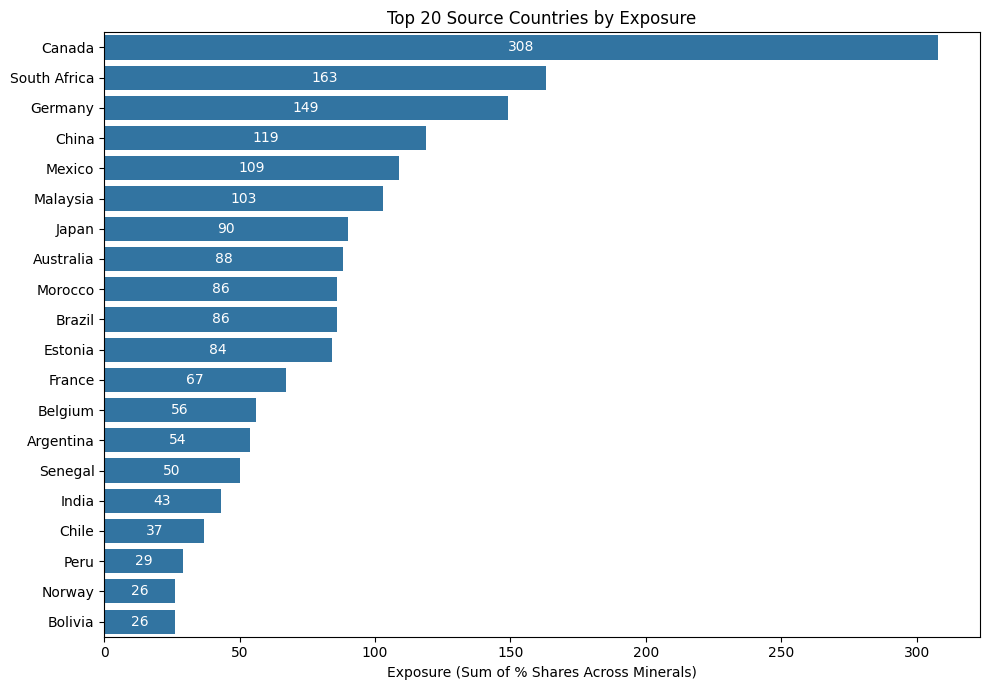

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20
top_sources = country_exposure.sort_values("exposure_sum", ascending=False).head(top_n)

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=top_sources,
    y="country",
    x="exposure_sum"
)

plt.title(f"Top {top_n} Source Countries by Exposure")
plt.xlabel("Exposure (Sum of % Shares Across Minerals)")
plt.ylabel("")

# ------------------------------------------------
# Add centered white labels inside bars
# ------------------------------------------------
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",
        label_type="center",
        color="white",
        fontsize=10
    )

plt.tight_layout()
plt.show()


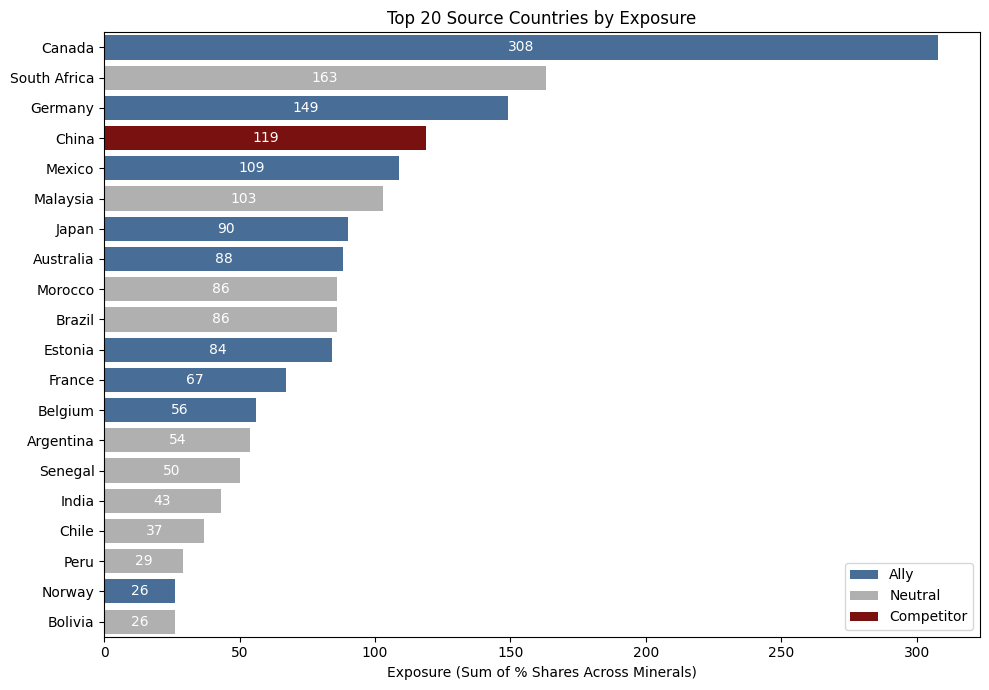

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure country_category is present
top_sources = (
    country_exposure
    .merge(
        df_sources_out[["country", "country_category"]].drop_duplicates(),
        on="country",
        how="left"
    )
    .sort_values("exposure_sum", ascending=False)
    .head(top_n)
)

# Define a clear, story-consistent palette
category_palette = {
    "Ally": "#3b6ea5",        # blue
    "Neutral": "#b0b0b0",     # gray
    "Competitor": "#8b0000"   # dark red
}

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=top_sources,
    y="country",
    x="exposure_sum",
    hue="country_category",
    dodge=False,
    palette=category_palette
)

plt.title(f"Top {top_n} Source Countries by Exposure")
plt.xlabel("Exposure (Sum of % Shares Across Minerals)")
plt.ylabel("")

# ------------------------------------------------
# Add centered white labels inside bars
# ------------------------------------------------
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",
        label_type="center",
        color="white",
        fontsize=10
    )

# Clean legend
ax.legend(title="", loc="lower right")

plt.tight_layout()
plt.show()


In [60]:
import plotly.express as px

# 1) Identify minerals where China is a source
china_minerals = (
    df_sources_out
    .query("country == 'China'")
    ["mineral"]
    .unique()
)

# 2) Filter melt to China-linked minerals only
melt_china = melt[melt["mineral"].isin(china_minerals)].copy()

# 3) Alphabetical order for minerals
alpha_order_china = sorted(melt_china["mineral"].unique())

# 4) Define the same blue → white → red colorscale
blue_red_scale = [
    [0.0, "#0b3c5d"],   # dark blue
    [0.25, "#3b6ea5"],  # blue
    [0.50, "#ffffff"], # white (midpoint)
    [0.75, "#d97a7a"], # light red
    [1.0, "#8b0000"]   # dark red
]

# 5) Plot heatmap
fig = px.density_heatmap(
    melt_china,
    x="scenario",
    y="mineral",
    z="shortfall_pct",
    category_orders={"mineral": alpha_order_china},
    color_continuous_scale=blue_red_scale,
    title="Estimated Shortfall Impact by Scenario (China-Linked Minerals)",
    labels={
        "shortfall_pct": "Estimated shortfall (%)",
        "scenario": "",
        "mineral": ""
    }
)

fig.update_layout(
    height=max(400, 30 * len(alpha_order_china)),
    coloraxis_colorbar=dict(title="Shortfall (%)")
)

fig.show()



In [67]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optional: only include minerals where the country share is at least this percent
min_share_threshold = 0  # set to 20 for "meaningful" dependencies

blue_red_scale = [
    [0.0, "#0b3c5d"],   # dark blue
    [0.25, "#3b6ea5"],  # blue

    [0.75, "#d97a7a"],  # light red
    [1.0, "#8b0000"]    # dark red
]

def build_country_heatmap_matrix(country: str, df_sources_out: pd.DataFrame, melt: pd.DataFrame, min_share: float):
    # Minerals linked to the given country (optionally above threshold)
    minerals = (
        df_sources_out.loc[
            (df_sources_out["country"] == country) & (df_sources_out["share_pct"] >= min_share),
            "mineral"
        ]
        .dropna()
        .unique()
    )

    melt_c = melt[melt["mineral"].isin(minerals)].copy()
    if melt_c.empty:
        return None, None, None

    minerals_sorted = sorted(melt_c["mineral"].unique())
    scenarios_sorted = list(melt_c["scenario"].dropna().unique())

    # Pivot to matrix: rows minerals, cols scenarios
    mat = (
        melt_c.pivot_table(index="mineral", columns="scenario", values="shortfall_pct", aggfunc="mean")
        .reindex(index=minerals_sorted, columns=scenarios_sorted)
    )

    z = mat.to_numpy()
    return minerals_sorted, scenarios_sorted, z


# Build matrices
y_china, x_china, z_china = build_country_heatmap_matrix("China", df_sources_out, melt, min_share_threshold)
y_russia, x_russia, z_russia = build_country_heatmap_matrix("Russia", df_sources_out, melt, min_share_threshold)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f"China-linked minerals",
        f"Russia-linked minerals"
    ),
    horizontal_spacing=0.08
)

# Add China heatmap with values
if z_china is not None:
    fig.add_trace(
        go.Heatmap(
            z=z_china,
            x=x_china,
            y=y_china,
            colorscale=blue_red_scale,
            zmin=0,
            zmax=100,
            text=z_china,
            texttemplate="%{text:.0f}",
            textfont=dict(color="white", size=11),
            colorbar=dict(title="Shortfall (%)"),
            showscale=True
        ),
        row=1, col=1
    )

# Add Russia heatmap with values (hide second colorbar)
if z_russia is not None:
    fig.add_trace(
        go.Heatmap(
            z=z_russia,
            x=x_russia,
            y=y_russia,
            colorscale=blue_red_scale,
            zmin=0,
            zmax=100,
            text=z_russia,
            texttemplate="%{text:.0f}",
            textfont=dict(color="white", size=11),
            showscale=False
        ),
        row=1, col=2
    )


fig.update_layout(
    title_text="Estimated Shortfall Impact by Scenario: China vs Russia",
    height=max(
        450,
        24 * max(len(y_china) if y_china else 0, len(y_russia) if y_russia else 0) + 200
    )
)

fig.show()


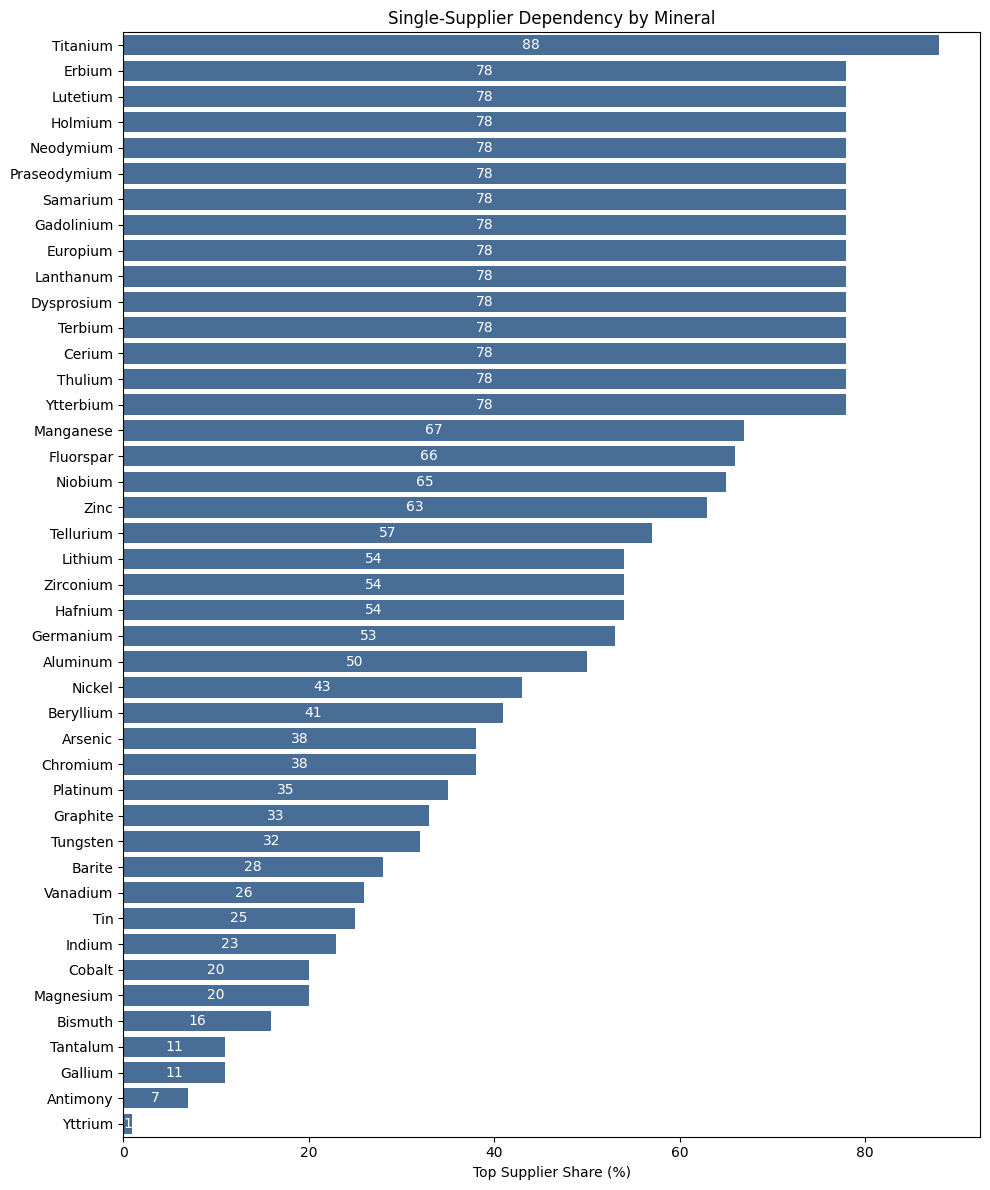

In [76]:
df_conc = (
    df_sources_out
    .drop_duplicates(subset=["mineral"])
    [["mineral", "top1_share_pct"]]
    .sort_values("top1_share_pct", ascending=False)
)

plt.figure(figsize=(10, 12))
ax = sns.barplot(
    data=df_conc,
    y="mineral",
    x="top1_share_pct",
    color="#3b6ea5"  # blue
)

plt.title("Single-Supplier Dependency by Mineral")
plt.xlabel("Top Supplier Share (%)")
plt.ylabel("")

for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",
        label_type="center",
        color="white",
        fontsize=10
    )

plt.tight_layout()
plt.show()


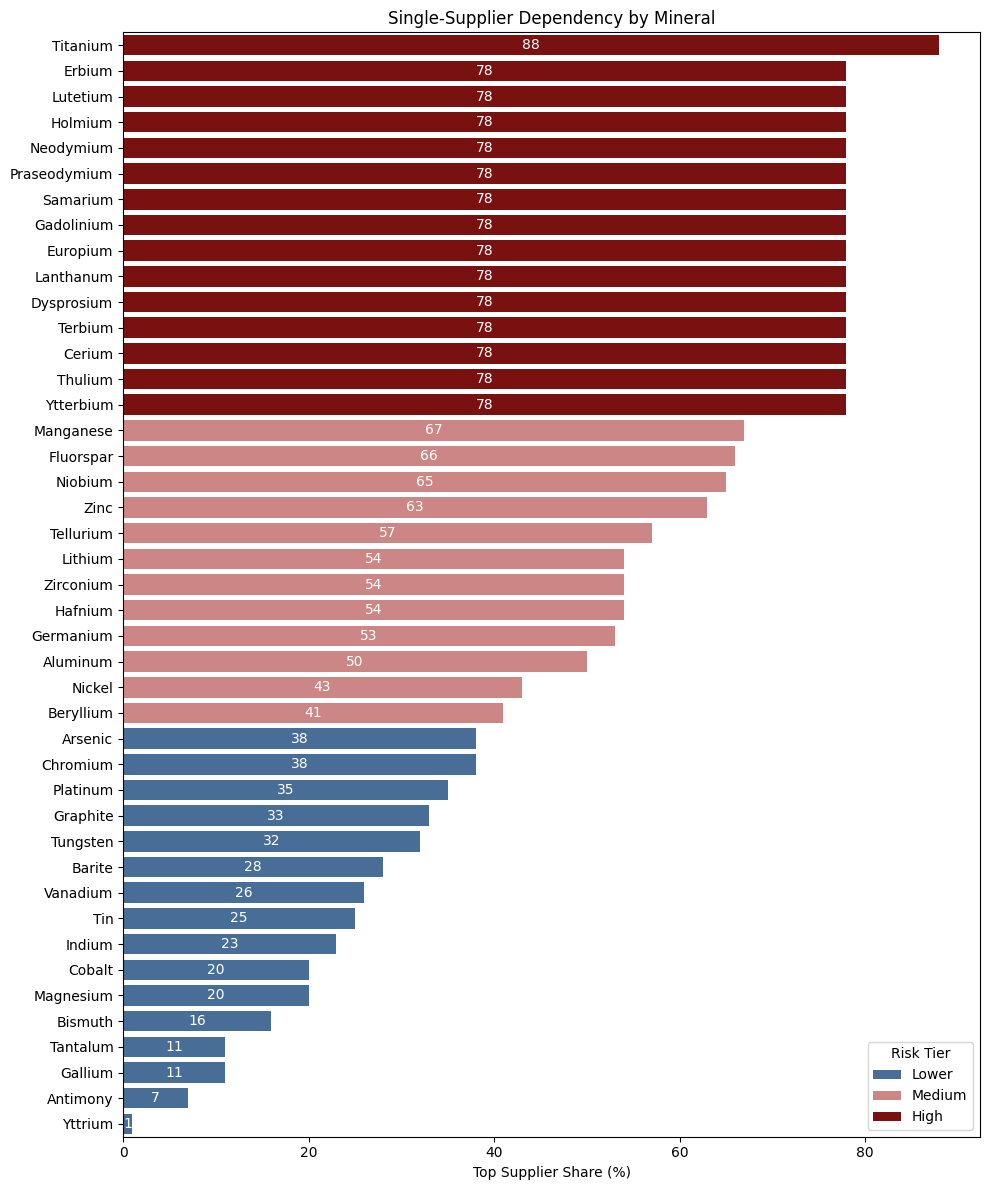

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------
# Add risk tier based on top supplier share
# ------------------------------------------------
df_conc = (
    df_sources_out
    .drop_duplicates(subset=["mineral"])
    [["mineral", "top1_share_pct"]]
    .assign(
        risk_tier=lambda d: pd.cut(
            d["top1_share_pct"],
            bins=[0, 40, 70, 100],
            labels=["Lower", "Medium", "High"],
            include_lowest=True
        )
    )
    .sort_values("top1_share_pct", ascending=False)
)

# Risk tier palette (aligned with your blue → red logic)
risk_palette = {
    "Lower": "#3b6ea5",   # blue
    "Medium": "#d97a7a",  # light red
    "High": "#8b0000"     # dark red
}

plt.figure(figsize=(10, 12))
ax = sns.barplot(
    data=df_conc,
    y="mineral",
    x="top1_share_pct",
    hue="risk_tier",
    dodge=False,
    palette=risk_palette
)

plt.title("Single-Supplier Dependency by Mineral")
plt.xlabel("Top Supplier Share (%)")
plt.ylabel("")

# ------------------------------------------------
# Centered white labels inside bars
# ------------------------------------------------
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",
        label_type="center",
        color="white",
        fontsize=10
    )

# Clean legend
ax.legend(title="Risk Tier", loc="lower right")

plt.tight_layout()
plt.show()





/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_34041/1454549261.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




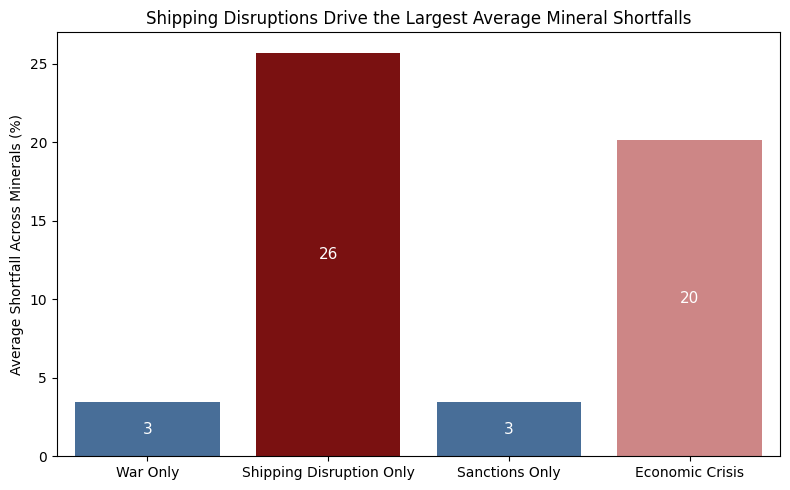

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If melt has multiple rows per mineral per scenario, average them
df_scenario = (
    melt.groupby(["scenario"], as_index=False)["shortfall_pct"].mean()
    .rename(columns={"shortfall_pct": "Average Shortfall (%)", "scenario": "Scenario"})
)

# Optional: set a consistent scenario order
scenario_order = ["War Only", "Shipping Disruption Only", "Sanctions Only", "Economic Crisis"]
df_scenario["Scenario"] = pd.Categorical(df_scenario["Scenario"], categories=scenario_order, ordered=True)
df_scenario = df_scenario.sort_values("Scenario")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_scenario,
    x="Scenario",
    y="Average Shortfall (%)",
    palette={
        "War Only": "#3b6ea5",
        "Sanctions Only": "#3b6ea5",
        "Economic Crisis": "#d97a7a",
        "Shipping Disruption Only": "#8b0000"
    }
)

plt.title("Shipping Disruptions Drive the Largest Average Mineral Shortfalls")
plt.xlabel("")
plt.ylabel("Average Shortfall Across Minerals (%)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="center", color="white", fontsize=11)

plt.tight_layout()
plt.show()




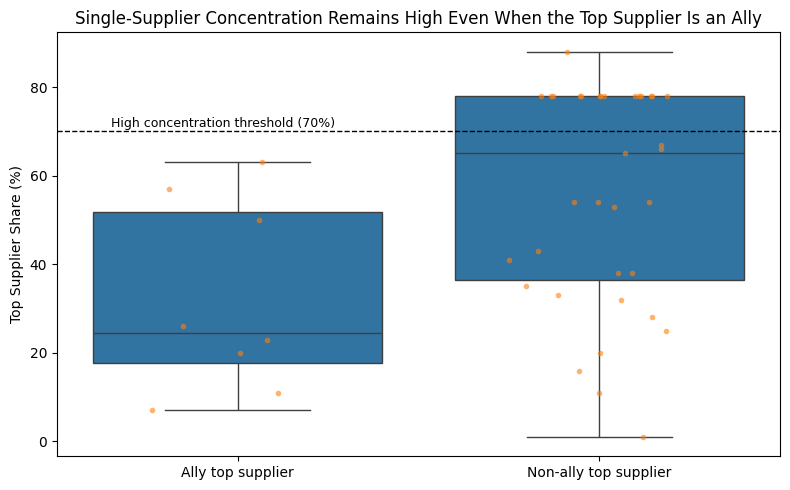

In [79]:
df = df_sources_out.copy()
df["share_pct"] = pd.to_numeric(df["share_pct"], errors="coerce")
df = df.dropna(subset=["mineral", "country", "share_pct", "country_category"])

# 1) Identify the top supplier country and its category for each mineral
top_supplier = (
    df.sort_values(["mineral", "share_pct"], ascending=[True, False])
      .groupby("mineral", as_index=False)
      .first()[["mineral", "country", "country_category", "share_pct"]]
      .rename(columns={
          "country": "top_supplier_country",
          "country_category": "top_supplier_category",
          "share_pct": "top_supplier_share_pct"
      })
)

# 2) Mineral-level concentration metric (top1 share) plus top supplier category
df_min = (
    df.drop_duplicates(subset=["mineral"])[["mineral", "top1_share_pct"]]
      .merge(top_supplier[["mineral", "top_supplier_category"]], on="mineral", how="left")
)

# 3) Friendly labels
df_min["top_supplier_group"] = df_min["top_supplier_category"].map({
    "Ally": "Top supplier is an ally",
    "Neutral": "Top supplier is neutral",
    "Competitor": "Top supplier is a competitor"
}).fillna("Unknown")

# Optional: focus the message on ally vs not-ally
df_min["ally_vs_not"] = df_min["top_supplier_category"].apply(
    lambda x: "Ally top supplier" if x == "Ally" else "Non-ally top supplier"
)

# 4) Plot: distribution comparison
plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=df_min,
    x="ally_vs_not",
    y="top1_share_pct"
)

# Add individual points for transparency
sns.stripplot(
    data=df_min,
    x="ally_vs_not",
    y="top1_share_pct",
    jitter=0.25,
    alpha=0.6,
    size=4
)

plt.title("Single-Supplier Concentration Remains High Even When the Top Supplier Is an Ally")
plt.xlabel("")
plt.ylabel("Top Supplier Share (%)")

# Optional: add a high-risk threshold line
plt.axhline(70, linestyle="--", linewidth=1, color="black")
plt.text(-0.35, 71, "High concentration threshold (70%)", fontsize=9)

plt.tight_layout()
plt.show()
